# Unraveling Gravitational Ripples: Neural Network Classification
### GASF vs FFT vs QTransform with New Data
### **GWGASF Members:** $Daniel\;Fredin^{1,2}$, $Cole\;Welch^{1,3}$, $Chia-Jui\;Chou^{4}$, $Andy\;Chen^{4}$, & $Shih-Chieh\;Hsu^{1}$
#### $^{1}University\;of\;Washington,\;Seattle\;USA$; $^{2}University\;of\;Massachusetts\;Lowell,\;Lowell\;USA$;$^{3}Georgia\;Institute\;of\;Technology,\;Atlanta\;USA$; $^{4}National\;Yang\;Ming\;Chiao\;Tung\;University,\;Hsinchu\;City,\;TW$

--------------------

In [37]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch import nn
from pyts.image import GramianAngularField
from tqdm import tqdm
import os
import random


from gasf.utils import h5_thang
# import random

# import h5py as h5
# from gasf.sampling import # Finish module import
# import ml4gw

# Initializes numpy and pytorch random seeds for reproducibility 
seed = 55
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [38]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cuda

NVIDIA GeForce GTX 1650
Memory Usage:
Allocated: 0.2 GB
Cached:    0.4 GB


# Preparing the data

##### need to modularize

In [39]:
# ### ------------- Load dataset ------------- ###


# # Loading datafiles and only load a slice of the total data.
# numSamples = 1500 # from each glitch/signal/background

# # bbh signals
# bbh_signals_filename = '/home/dfredin/gwgasf/data/raw_data/bbh_dataset_p1.hdf5'
# bbh_info = h5_thang(bbh_signals_filename)
# bbh_keys = bbh_info.h5_keys()
# H1_bbh = bbh_info.h5_data()['H1'][0:numSamples]
# L1_bbh = bbh_info.h5_data()['L1'][0:numSamples]

# # H1 background
# H1_bg_filename = '/home/dfredin/gwgasf/data/raw_data/H1_bg_dataset_p1.hdf5'
# H1_bg_info = h5_thang(H1_bg_filename)
# H1_bg_keys = H1_bg_info.h5_keys()
# H1_bg = H1_bg_info.h5_data()['background_noise'][0:numSamples]
# # L1 background
# L1_bg_filename = '/home/dfredin/gwgasf/data/raw_data/L1_bg_dataset_p1.hdf5'
# L1_bg_info = h5_thang(L1_bg_filename)
# L1_bg_keys = L1_bg_info.h5_keys()
# L1_bg = L1_bg_info.h5_data()['background_noise'][0:numSamples]

# # H1 glitch
# H1_glitch_filename = '/home/dfredin/gwgasf/data/raw_data/H1_glitch_dataset_p1.hdf5'
# H1_glitch_info = h5_thang(H1_glitch_filename)
# H1_glitch_keys = H1_glitch_info.h5_keys()
# H1_glitch = H1_glitch_info.h5_data()['glitch'][0:numSamples]
# # L1 glitch
# L1_glitch_filename = '/home/dfredin/gwgasf/data/raw_data/L1_glitch_dataset_p1.hdf5'
# L1_glitch_info = h5_thang(L1_glitch_filename)
# L1_glitch_keys = L1_glitch_info.h5_keys()
# L1_glitch = L1_glitch_info.h5_data()['glitch'][0:numSamples]

# # # hfsg signals
# # hfsg_signals_filename = '/home/dfredin/gwgasf/data/raw_data/hfsg_dataset_p1.hdf5'
# # hfsg_info = h5_thang(hfsg_signals_filename)
# # hfsg_keys = hfsg_info.h5_keys()
# # H1_hfsg = hfsg_info.h5_data()['H1'][0:numSamples]
# # L1_hfsg = hfsg_info.h5_data()['L1'][0:numSamples]
# # # lfsg signals
# # lfsg_signals_filename = '/home/dfredin/gwgasf/data/raw_data/lfsg_dataset_p1.hdf5'
# # lfsg_info = h5_thang(lfsg_signals_filename)
# # lfsg_keys = lfsg_info.h5_keys()
# # H1_lfsg = lfsg_info.h5_data()['H1'][0:numSamples]
# # L1_lfsg = lfsg_info.h5_data()['L1'][0:numSamples]

# # variables = [H1_bbh, L1_bbh, H1_bg, H1_glitch, L1_bg, L1_glitch, H1_hfsg, L1_hfsg, H1_lfsg, L1_lfsg]
# # names = ['H1 BBH', 'L1 BBH', 'H1 BG', 'H1 Glitch', 'L1 BG', 'L1 Glitch', 'H1 HFSG', 'L1 HFSG', 'H1 LFSG', 'L1 LFSG']

# # for name, var in zip(names, variables):
# #     print(f"{name} Shape: {var.shape}")

# variables = [H1_bbh, L1_bbh, H1_bg, H1_glitch, L1_bg, L1_glitch]
# names = ['H1 BBH', 'L1 BBH', 'H1 BG', 'H1 Glitch', 'L1 BG', 'L1 Glitch']

# for name, var in zip(names, variables):
#     print(f"{name} Shape: {var.shape}")

In [40]:
# ### ------------- HIGH SNR GLITCH ------------- ###

# # This code block filters glitch signals based on their signal-to-noise ratio (SNR) 
# H1_glitch_snr = H1_glitch_info.h5_data()['glitch_info']
# L1_glitch_snr = L1_glitch_info.h5_data()['glitch_info']

# # Filter glitch signals with SNR >= 10 for H1 detector
# h1_indices = np.where(H1_glitch_snr['snr'] >= 0)
# H1_glitch_snr_high = H1_glitch_info.h5_data()['glitch'][h1_indices]

# # Filter glitch signals with SNR >= 10 for L1 detector
# l1_indices = np.where(L1_glitch_snr['snr'] >= 0)
# L1_glitch_snr_high = L1_glitch_info.h5_data()['glitch'][l1_indices]

# # Truncate the glitch signals to have the same length
# H1_glitch_snr_high = H1_glitch_snr_high[0:(numSamples)]
# L1_glitch_snr_high = L1_glitch_snr_high[0:(numSamples)]

# # Create a stack of high SNR glitch signals from both detectors
# glitch_highsnr_signals = np.dstack((H1_glitch_snr_high, L1_glitch_snr_high))

# # Assign the stack of glitch signals to the final variable
# glitch_signals = glitch_highsnr_signals

# # Clean up variables to free up memory
# del L1_glitch_snr_high, H1_glitch_snr_high, H1_glitch_snr, L1_glitch_snr, glitch_highsnr_signals

In [41]:
# ### ------------- STACK ARRAYS ------------- ###

# ## Stacking the arrays for the H1 and L1 detectors

# bbh_signals = np.dstack((H1_bbh, L1_bbh))
# bg_signals = np.dstack((H1_bg, L1_bg))
# # TODO: Add the other high SNR glitches
# # glitch_signals = np.dstack((H1_glitch, L1_glitch))
# # hfsg_signals = np.dstack((H1_hfsg, L1_hfsg))
# # lfsg_signals = np.dstack((H1_lfsg, L1_lfsg))

# del H1_bbh, L1_bbh, H1_bg, L1_bg, H1_glitch, L1_glitch

# # variables = [bbh_signals, bg_signals, glitch_signals, hfsg_signals, lfsg_signals]
# # names = ['BBH Signals', 'BG Signals', 'Glitch Signals', 'HFSG Signals', 'LFSG Signals']

# # for name, var in zip(names, variables):
# #     print(f"{name} Shape: {var.shape}")

# x_train = np.concatenate((glitch_signals, bbh_signals, bg_signals))
# x_train.shape
# # x_train = np.concatenate((glitch_train, bbh_train, overlap_train), axis=0).transpose((0,2,1))


In [42]:
# ## ---------------- ONE-HOT ENCODING ----------------------------##

# # NOTE: 
# # Multiclassifier
# anomaly_class = {
#     'Glitch': [1, 0, 0],
#     'Signal': [0, 1, 0],
#     'Background': [0, 0, 1]
# }

# glitch_train_ids = np.full((glitch_signals.shape[0], 3), anomaly_class['Glitch'])
# bbh_train_ids = np.full((bbh_signals.shape[0], 3), anomaly_class['Signal'])
# bg_train_ids = np.full((bg_signals.shape[0], 3), anomaly_class['Background'])


# y_train_ids = np.concatenate((glitch_train_ids, bbh_train_ids, bg_train_ids), axis=0)
# del bbh_signals, bg_signals, glitch_signals
# del glitch_train_ids, bbh_train_ids, bg_train_ids

In [43]:
# n_train = 4500

# # Generate the idx_train, idx_val to randomly sample from the training set and validation set.
# idx_train = np.random.randint(0, len(x_train), size=n_train)
# idx_train = np.arange(0, n_train)
# y_train = y_train_ids[idx_train]

# ### ------------- GASF CONVERSION ------------- ###

# GASF = GramianAngularField(image_size=194, sample_range = (-1,1), method="summation")
# # Convert training data to image format
# img_x_train_dec1 = GASF.transform(x_train[idx_train,:,0])
# img_x_train_dec2 = GASF.transform(x_train[idx_train,:,1])

# img_x_train = np.stack((img_x_train_dec1, img_x_train_dec2), axis=1)
# del img_x_train_dec1, img_x_train_dec2


In [44]:
# gasf_filename = '/home/dfredin/gwgasf/data/gasf_data/gasf_data.hdf5'


# gasf_info = h5_thang(gasf_filename)
# gasf_keys = gasf_info.h5_keys()

# bbh_gasf = gasf_info.h5_data()['bbh']
# bg_gasf = gasf_info.h5_data()['bg']
# glitch_gasf = gasf_info.h5_data()['glitch']



# bbh_gasf_id = gasf_info.h5_data()['bbh_label']
# bg_gasf_id = gasf_info.h5_data()['bg_label']
# glitch_gasf_id = gasf_info.h5_data()['glitch_label']

In [45]:
# img_x_train = np.concatenate((glitch_gasf, bbh_gasf, bg_gasf), axis=0)
# y_train = np.concatenate((glitch_gasf_id, bbh_gasf_id, bg_gasf_id), axis=0)

In [46]:
import h5py

def load_gasf_from_hdf5(file_path, num_bbh, num_bg, num_glitch):
    """Load GASF data and labels from HDF5 file."""
    with h5py.File(file_path, 'r') as f:
        data = {
            'bbh': np.array(f['bbh'][:num_bbh]),
            'bg': np.array(f['bg'][:num_bg]),
            'glitch': np.array(f['glitch'][:num_glitch])
        }
        labels = {
            'bbh': np.array(f['bbh_label'][:num_bbh]),
            'bg': np.array(f['bg_label'][:num_bg]),
            'glitch': np.array(f['glitch_label'][:num_glitch])
        }
    return data, labels

file = '/home/dfredin/gwgasf/data/gasf_data/gasf_data.hdf5'
gasf_data, labels = load_gasf_from_hdf5(file, 300, 300, 300)

In [47]:
def split_dataset(data, labels, train_ratio, test_ratio, val_ratio):
    """Split data into training, testing, and validation sets using ratios from config."""
    def split(data, train_ratio, test_ratio, val_ratio):
        total_samples = len(data)
        num_train = int(train_ratio * total_samples)
        num_test = int(test_ratio * total_samples)
        num_val = total_samples - num_train - num_test

        return data[:num_train], data[num_train:num_train + num_test], data[num_train + num_test:]

    train_ratio = train_ratio
    test_ratio = test_ratio
    val_ratio = val_ratio

    # Split each type of data
    split_data = {key: split(data[key], train_ratio, test_ratio, val_ratio) for key in data}
    split_labels = {key: split(labels[key], train_ratio, test_ratio, val_ratio) for key in labels}

    # Concatenate the splits to form the combined structure
    strains = {
        'training': np.concatenate([split_data['glitch'][0], split_data['bbh'][0], split_data['bg'][0]]),
        'testing': np.concatenate([split_data['glitch'][1], split_data['bbh'][1], split_data['bg'][1]]),
        'validation': np.concatenate([split_data['glitch'][2], split_data['bbh'][2], split_data['bg'][2]])
    }

    targets = {
        'training': np.concatenate([split_labels['glitch'][0], split_labels['bbh'][0], split_labels['bg'][0]]),
        'testing': np.concatenate([split_labels['glitch'][1], split_labels['bbh'][1], split_labels['bg'][1]]),
        'validation': np.concatenate([split_labels['glitch'][2], split_labels['bbh'][2], split_labels['bg'][2]])
    }

    return strains, targets


strains, targets = split_dataset(gasf_data, labels, 0.8, 0.10, 0.10)


In [48]:
# ### ------------- Split into training and validation datasets ------------- ###

# # Assuming img_x_train is defined and has the shape (N, 2, 194, 194)
# # Assuming y_train is defined and has the shape (N, 3), where N can be any integer

# # Total number of samples
# total_samples = img_x_train.shape[0]

# # Calculate the number of samples in each dataset
# ## NOTE: MAYBE USER INPUT FOR SPLIT %???
# num_train = int(0.8 * total_samples)  # 80% for training
# num_test = int(0.15 * total_samples)  # 15% for testing
# num_val = total_samples - num_train - num_test  # Remaining 5% for validation, adjusted to avoid rounding issues

# # Create training, testing, and validation datasets for img_x_train
# x_train_data = img_x_train[:num_train]
# x_test_data = img_x_train[num_train:num_train + num_test]
# x_val_data = img_x_train[num_train + num_test:]

# # Create training, testing, and validation datasets for y_train
# y_train_data = y_train[:num_train]
# y_test_data = y_train[num_train:num_train + num_test]
# y_val_data = y_train[num_train + num_test:]

# # Print shapes to verify the distribution
# strains = [x_train_data, x_test_data, x_val_data]
# targets = [y_train_data, y_test_data, y_val_data]
# labels = ['Training', 'Testing', 'Validation']

# # Collecting and printing the shape of each array
# array_shapes = [arr.shape for arr in strains]
# for i, shape in enumerate(array_shapes):
#     print(f"{labels[i]} Data Shape: {shape}")

# array_shapes = [arr.shape for arr in targets]
# for i, shape in enumerate(array_shapes):
#     print(f"{labels[i]} Targets Shape: {shape}")


In [49]:
# # Collecting and printing the shape of each array
# array_shapes = [arr.shape for arr in strains]
# for i, shape in enumerate(array_shapes):
#     print(f"{labels[i]} Data Shape: {shape}")

# array_shapes = [arr.shape for arr in targets]
# for i, shape in enumerate(array_shapes):
#     print(f"{labels[i]} Targets Shape: {shape}")

# Test Plots

In [50]:
# # Glitch Plot

# y_train_label = str(y_train[0])
# # Create a new figure for the glitch plot
# plt.figure(figsize=(10, 6))
# plt.plot(x_train[idx_train, :, 0][0])  # Adjusted the indexing based on typical data structure
# plt.title(f'Label: {y_train_label}')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.show()

# # Create a new figure for the glitch GASF plot
# plt.figure(figsize=(10, 6))
# plt.imshow(img_x_train[:,0,:,:][0], cmap='rainbow', origin='lower')
# plt.title(f'Label: {y_train_label}')
# plt.show()


# # Signal Plot

# y_train_label = str(y_train[548])
# # Create a new figure for the signal plot
# plt.figure(figsize=(10, 6))
# plt.plot(x_train[idx_train,:,0][548])
# plt.title(f'Label: {y_train_label}')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.show()

# # Create a new figure for the signal GASF plot
# plt.figure(figsize=(10, 6))
# plt.imshow(img_x_train[:,0,:,:][548], cmap='rainbow', origin='lower')
# plt.title(f'Label: {y_train_label}')
# plt.show()


# # Background Plot

# y_train_label = str(y_train[55])
# # Create a new figure for the Background plot
# plt.figure(figsize=(10, 6))
# plt.plot(x_train[idx_train,:,0][55])
# plt.title(f'Label: {y_train_label}')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.show()

# # Create a new figure for the Background GASF plot
# plt.figure(figsize=(10, 6))
# plt.imshow(img_x_train[:,0,:,:][55], cmap='rainbow', origin='lower')
# plt.title(f'Label: {y_train_label}')
# plt.show()

# DataLoader

In [51]:
class MyDataset(Dataset):

    def __init__(self, data, target, ifos=3, kernel_size=4096):

        # Get data type from https://pytorch.org/docs/stable/tensors.html
        # self.data = torch.FloatTensor(
        #     data.reshape([-1, ifos, kernel_size])
        # )
        # 
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(target)
    
    def __len__(self):
        
        return len(self.data)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        return x, y

In [52]:
strains['training'][0,0,0,0]

-0.9827783595561468

In [53]:
strains['training'][0,0,193,193]

-0.9808086182446272

In [54]:
set_seed(55)
# Load Training data into pytorch tensor
dataset = MyDataset(strains['training'], targets['training'])
training_data = DataLoader(
    dataset, 
    batch_size=32, 
    shuffle=True
)

# Load testing data into pytorch tensor
dataset_t = MyDataset(strains['testing'], targets['testing'])
testing_data = DataLoader(
    dataset_t, 
    batch_size=32, 
    shuffle=False
)


# Load Validation data into pytorch tensor
dataset_v = MyDataset(strains['validation'], targets['validation'])
validation_data = DataLoader(
    dataset_v, 
    batch_size=32, 
    shuffle=False
)

# CNN Model

In [55]:

               ## # | 64 x 64 | 127 x 127 | 194 x 194 |
cnn1In = 2     ## # |    2    |     2     |     2     |
cnn1Out = 64   ## # |    16   |     16    |     16    |    
cnn1K = 6      ## # |    4    |     5     |     6     |
cnn1S = 2      ## # |    2    |     2     |     2     |
cnn1P = 1      ## # |    1    |     2     |     1     |
batch1 = 64    ## # |    16   |     16    |     16    |
max1K = 5      ## # |    4    |     2     |     5     |
max1S = 3      ## # |    2    |     2     |     3     |
max1P = 1      ## # |    1    |     0     |     1     |

cnn2In = 64    ## # |    16   |     16    |     16    |
cnn2Out = 128   ## # |    32   |     32    |     32    |
cnn2K = 4      ## # |    3    |     4     |     4     |
cnn2S = 2      ## # |    1    |     2     |     2     |
cnn2P = 1      ## # |    1    |     1     |     1     |
batch2 = 128    ## # |    32   |     32    |     32    |
max2K = 2      ## # |    2    |     2     |     2     |
max2S = 2      ## # |    2    |     2     |     2     |
max2P = 0      ## # |    0    |     0     |     0     |

### -------------194 x 194 Model Definition------------- ###

class CNNModel(nn.Module):
    
    def __init__(self):
        
        super(CNNModel, self).__init__()

                # First convolution layer (2 channel -> 16 channels, preserve original dimension by adding padding = 2) 
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=cnn1Out, kernel_size=cnn1K, stride=cnn1S, padding=cnn1P),
            nn.ReLU(),
            nn.BatchNorm2d(batch1),
            nn.MaxPool2d(kernel_size=max1K, stride=max1S, padding=max1P)
            )
        
        # Second convolution layer (16 channel -> 32 channels, preserve dimension by adding padding = 2)
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=cnn2In, out_channels=cnn2Out, kernel_size=cnn2K, stride=cnn2S, padding=cnn2P),
            nn.ReLU(),
            nn.BatchNorm2d(batch2),
            nn.MaxPool2d(kernel_size=max2K, stride=max2S, padding=max2P)
            )

        # Fully connected layer that takes the flattened output of layer 2 (32, 8 ,8) -> (2048) and output 2 classes
        self.fc1 = nn.Linear(in_features=128*8*8, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=3)
        self.dropcnn = nn.Dropout(0.25)
        self.dropfc = nn.Dropout(0.6)

    
    def forward(self, x):

        # input image -> conv -> batchnorm -> relu -> maxpool
        out = self.layer1(x)
        out = self.dropcnn(out)
        # 1st maxpool output -> conv -> batchnorm -> relu -> maxpool
        out = self.layer2(out)
        out = self.dropcnn(out)
        # flatten the second maxpool output to be used as input into FCN layer
        out = out.view(out.size(0), -1)

        # Pass flattened output into FCN layers
        out = self.fc1(out)
        out = self.dropfc(out)
        out = self.fc2(out)
        out = self.dropfc(out)
        out = self.fc3(out)
        
        return out

## Hyperparameters

In [56]:
  ### -------------Hyperparameters------------- ###
set_seed(55)

# Initialize the CNN model
GASF_Model = CNNModel().to(device)

# An easy way to give you the outline of your model
summary(GASF_Model,  (2, 194, 194), len(training_data.dataset))

learning_rate = 0.0005     # 0.00005
epochs = 3                 # 40
# batchsize = 225             # 768
L2_reg = 0.001            # 0.00005

# Define loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    GASF_Model.parameters(), 
    lr = learning_rate, 
    weight_decay=L2_reg)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [707, 64, 96, 96]           4,672
              ReLU-2          [707, 64, 96, 96]               0
       BatchNorm2d-3          [707, 64, 96, 96]             128
         MaxPool2d-4          [707, 64, 32, 32]               0
           Dropout-5          [707, 64, 32, 32]               0
            Conv2d-6         [707, 128, 16, 16]         131,200
              ReLU-7         [707, 128, 16, 16]               0
       BatchNorm2d-8         [707, 128, 16, 16]             256
         MaxPool2d-9           [707, 128, 8, 8]               0
          Dropout-10           [707, 128, 8, 8]               0
           Linear-11                [707, 1024]       8,389,632
          Dropout-12                [707, 1024]               0
           Linear-13                 [707, 512]         524,800
          Dropout-14                 [7

# Training

In [57]:
cost_value = np.empty(epochs)
cost_valid_value = np.empty(epochs)

for i in range(epochs):
    GASF_Model.train()
    t_cost = 0
    for j, (x, y) in enumerate(tqdm(training_data, desc=f'Epoch {i+1}')):
        x = x.to(device)
        y = y.to(device)        
        p_value = GASF_Model(x)
        cost = loss_func(p_value, y)  # Assuming y contains class indices        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()    
        t_cost += cost.item()

    cost_value[i] = t_cost / (j + 1)
        
    print('========')
    print(f'Cost {round(cost_value[i], 2)}')
    print('========', '\n')

    GASF_Model.eval()
    with torch.no_grad():
        v_cost = 0
        for run, (a, b) in enumerate(validation_data):
            a = a.to(device)
            b = b.to(device)            
            p_value = GASF_Model(a)
            cost_valid = loss_func(p_value, b)  # Assuming b contains class indices            
            v_cost += cost_valid.item()
            
        cost_valid_value[i] = v_cost / (run + 1)
        
        print('===================')
        print(f'Validation Cost {round(cost_valid_value[i], 2)}')
        print('===================', '\n')



# Save the model
model_save_path='/home/dfredin/gwgasf/models/gasf_model.pth'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
torch.save(GASF_Model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

# torch.save(GASF_Model, model_save_path)


Epoch 1: 100%|██████████| 23/23 [00:00<00:00, 24.17it/s]


Cost 2.67

Validation Cost 2.77



Epoch 2: 100%|██████████| 23/23 [00:00<00:00, 25.00it/s]


Cost 1.86

Validation Cost 1.29



Epoch 3: 100%|██████████| 23/23 [00:00<00:00, 23.47it/s]


Cost 1.18

Validation Cost 0.78

Model saved to /home/dfredin/gwgasf/models/gasf_model.pth


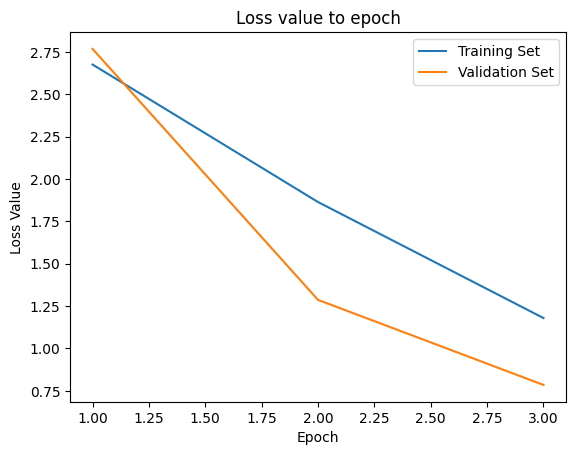

In [58]:
total_epoch = np.linspace(1, epochs, epochs)
plt.title('Loss value to epoch')
plt.plot(total_epoch, cost_value, label = 'Training Set')
plt.plot(total_epoch, cost_valid_value, label = 'Validation Set')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
train_val_Lossplot_filename = '/home/dfredin/gwgasf/results/figures/train_val_Loss.png'
plt.savefig(train_val_Lossplot_filename, bbox_inches = 'tight')
plt.show()
plt.close()

-------

## Confusion Matrix Analysis

In [59]:
# torch tensor device check

if device.type == 'cpu':
    dtype = torch.FloatTensor
elif device.type =='cuda':
    dtype = torch.cuda.FloatTensor

100%|██████████| 3/3 [00:00<00:00, 109.23it/s]


tensor([29., 30., 30.], device='cuda:0')
[[0.96551724 0.26666667 0.1       ]
 [0.         0.2        0.1       ]
 [0.03448276 0.53333333 0.8       ]]
Precision: 0.6551724137931035
Recall: 0.6551724137931035
F1 Score: 0.6551724137931035
TPR: 0.9655172413793104
FAR: 0.21641791044776118


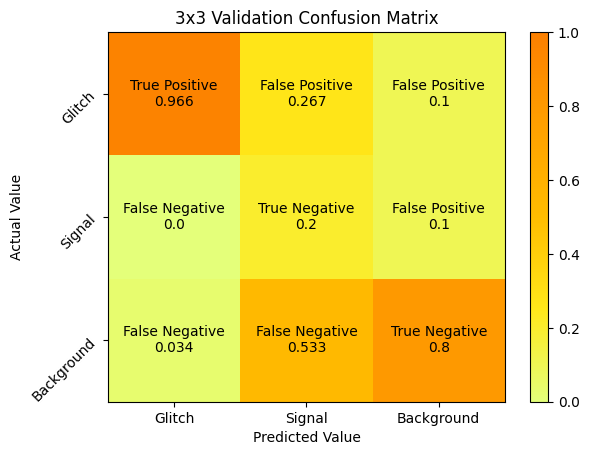

100%|██████████| 23/23 [00:00<00:00, 82.01it/s]


tensor([227., 240., 240.], device='cuda:0')
[[0.81497797 0.24166667 0.06666667]
 [0.10132159 0.2875     0.13333333]
 [0.08370044 0.47083333 0.8       ]]
Precision: 0.6341593245227607
Recall: 0.6341593245227607
F1 Score: 0.6341593245227607
TPR: 0.8149779735682819
FAR: 0.2287113921411945


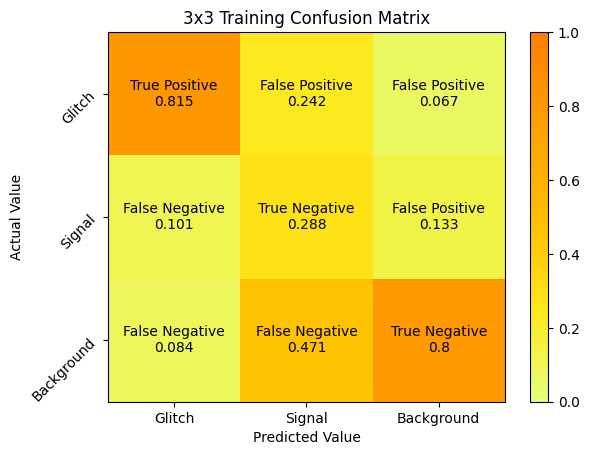

100%|██████████| 3/3 [00:00<00:00, 65.49it/s]


tensor([28., 30., 30.], device='cuda:0')
[[0.92857143 0.16666667 0.03333333]
 [0.07142857 0.36666667 0.16666667]
 [0.         0.46666667 0.8       ]]
Precision: 0.6984126984126985
Recall: 0.6984126984126985
F1 Score: 0.6984126984126985
TPR: 0.9285714285714286
FAR: 0.15217391304347824


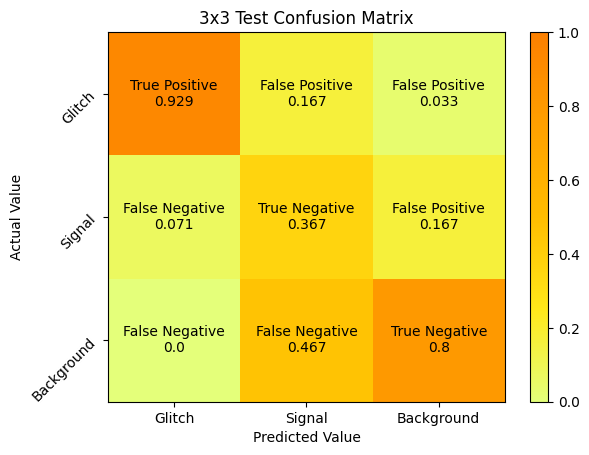

In [60]:
def calculate_metrics(conf_matrix):
    # Calculate precision, recall, and F1 score for the entire model
    TP = np.sum(np.diag(conf_matrix))  # True Positives
    FP = np.sum(np.sum(conf_matrix, axis=0) - np.diag(conf_matrix))  # False Positives
    FN = np.sum(np.sum(conf_matrix, axis=1) - np.diag(conf_matrix))  # False Negatives

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1_score

def plot_confusion_matrix(data, title):
    num_classes = 3
    conf_matrix = torch.zeros([num_classes,num_classes]).to(device)
    num_count = torch.zeros([num_classes]).to(device)
    GASF_Model.eval()
    with torch.no_grad():
        for num, (x, y) in enumerate(tqdm(data)):
            Real_label = y.to(device)

            # Convert sofmax output to onehot
            max_class = torch.argmax(GASF_Model(x.to(device)), axis=1)
            pred = F.one_hot(max_class, num_classes=num_classes)

            # Accumlating statical value
            conf_matrix += torch.matmul(pred.T.type(dtype), Real_label.type(dtype))
            num_count += Real_label.sum(axis=0)

        print(num_count)
        num_count = num_count.detach().cpu().numpy().astype('float64')
        conf_matrix = conf_matrix.detach().cpu().numpy().astype('float64')

    # Normalize the confusion matrix.
    conf_matrix /= num_count

    precision, recall, f1_score = calculate_metrics(conf_matrix)
    print(conf_matrix)
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1_score}')
    TPR = conf_matrix[0, 0]
    FAR = conf_matrix[0, 1] / (conf_matrix[0, 0] + conf_matrix[0, 1])

    print(f'TPR: {TPR}')
    print(f'FAR: {FAR}')

    # Labels for a 3x3 confusion matrix
    lab = np.array([['True Positive', 'False Positive', 'False Positive'], 
                    ['False Negative', 'True Negative', 'False Positive'],
                    ['False Negative', 'False Negative', 'True Negative']])


    plt.figure()
    color = plt.pcolormesh([conf_matrix[2], conf_matrix[1], conf_matrix[0]], cmap = 'Wistia', vmin=0, vmax=1)

    # Adjust the loop for a 3x3 matrix
    for i in range(3):
        for j in range(3):
            plt.text(i+.5, j+.5, 
                     f'{lab[2-j, i]}\n{round(conf_matrix[2-j, i], 3)}', 
                     ha='center', 
                     va='center')

    # Update the ticks for three classes
    plt.xticks([.5, 1.5, 2.5], ['Glitch', 'Signal', 'Background'])
    plt.yticks([.5, 1.5, 2.5], ['Background', 'Signal', 'Glitch'], rotation=45)
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title(f'3x3 {title} Confusion Matrix')
    plt.colorbar(color)
    plt.savefig(f'/home/dfredin/gwgasf/results/figures/{title}_confuMatrix.png', bbox_inches = 'tight')
    plt.show()
    plt.close()

# Call the function for each of your datasets
plot_confusion_matrix(validation_data, 'Validation')
plot_confusion_matrix(training_data, 'Training')
plot_confusion_matrix(testing_data, 'Test')

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import pandas as pd

def calculate_confusion_matrix(loaded_best_model, dataloader, device, num_classes=3):
    """Calculate confusion matrix using sklearn's confusion_matrix."""
    model = loaded_best_model
    device = device
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(torch.argmax(y, 1).cpu().numpy())
    
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=range(num_classes), normalize='true')


    print(precision_recall_fscore_support(all_labels, all_preds, labels=range(num_classes)))



    # print(classification_report(all_labels, all_preds, labels=range(num_classes)))
    return conf_matrix

100%|██████████| 23/23 [00:00<00:00, 69.77it/s]

(array([0.71428571, 0.55645161, 0.59259259]), array([0.81497797, 0.2875    , 0.8       ]), array([0.76131687, 0.37912088, 0.68085106]), array([227, 240, 240]))


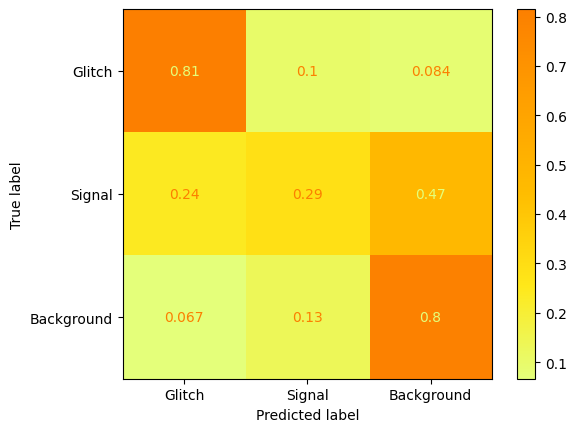

In [72]:
conf_matrix = calculate_confusion_matrix(GASF_Model, training_data, device)
conf_matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Glitch', 'Signal', 'Background'])
disp.plot(include_values=True, cmap='Wistia', ax=None, xticks_rotation='horizontal')


100%|██████████| 3/3 [00:00<00:00, 62.53it/s]

(array([0.8125    , 0.61111111, 0.63157895]), array([0.92857143, 0.36666667, 0.8       ]), array([0.86666667, 0.45833333, 0.70588235]), array([28, 30, 30]))


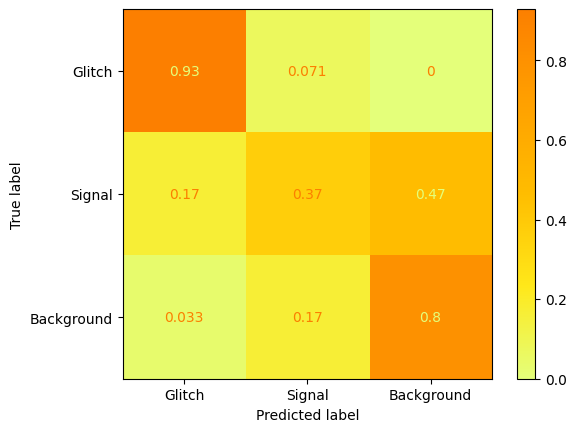

In [73]:
conf_matrix = calculate_confusion_matrix(GASF_Model, testing_data, device)
conf_matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Glitch', 'Signal', 'Background'])
disp.plot(include_values=True, cmap='Wistia', ax=None, xticks_rotation='horizontal')

100%|██████████| 3/3 [00:00<00:00, 63.94it/s]

(array([0.71794872, 0.66666667, 0.58536585]), array([0.96551724, 0.2       , 0.8       ]), array([0.82352941, 0.30769231, 0.67605634]), array([29, 30, 30]))


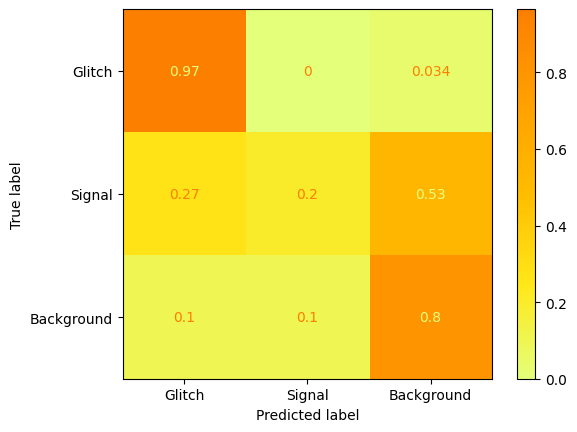

In [74]:
conf_matrix = calculate_confusion_matrix(GASF_Model, validation_data, device)
conf_matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Glitch', 'Signal', 'Background'])
disp.plot(include_values=True, cmap='Wistia', ax=None, xticks_rotation='horizontal')